# Linear fit of Bouguer lines on  Pic Du Midi Data with Gaussian Processes


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in
https://github.com/sylvielsstfr/SpectractorAnaAtm19/blob/master/ana_20190215_HD116405_Filtre_None/convertSpectraToPandas.py


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 28th 2020
- update : September 28th 2020 : 



# Import

In [32]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [33]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [34]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [35]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,ConstantKernel

In [37]:
from scipy import interpolate

# Functions

In [38]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [39]:
def GetSpectra(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectra(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        #if idx>160 and idx<200:
        #    idx+=1
        #    continue
        
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
      
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [40]:
def GetSpectraFiltered(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        if idx>160 and idx<200:
            idx+=1
            continue
        if idx>220 and idx<226:
            idx+=1
            continue
        if idx>275 and idx<295:
        #if idx>260 and idx<295:
            idx+=1
            continue
            
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [41]:
def GetSpectraFiltered_clean(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        if idx>150 and idx<183:
            idx+=1
            continue
            
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [42]:
def ConvertToImage(all_df,WLMIN=350,WLMAX=1100):
    """
    ConvertToImage(all_df,WLMIN=350,WLMAX=1100)
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of relative magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        fcn = interpolate.interp1d(df.wavelength,df.mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(df.wavelength,df.errmag,bounds_error=False,fill_value=(0,0))
        
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        airm_table[idx]  = df.airmass[0]
        time_table[idx]  = df.time[0]
        
    return WL, mag_table, emag_table ,airm_table,time_table
       

In [43]:
def GetBouguerLinesTim(Npoints,wl,tim,magref,emag,FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth = 1)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs time")
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return 
     

In [44]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref,emag ,FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags
     

In [45]:
def GetBouguerLinesGP(Npoints,wl,airmass,magref,emag ,FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 0.1, ecolor=all_colors[idx], elinewidth = .1)
    
        # fit
        gp = GaussianProcessRegressor(kernel=my_kernel,normalize_y=True,alpha=the_ey**2,n_restarts_optimizer=10)
        gp.fit(the_x[:,np.newaxis], the_y)
        y_mean, y_std = gp.predict(x_fit[:, np.newaxis], return_std=True)
           
        nstd=1
        y_fit=y_mean
        y_fit_up=y_mean+nstd*y_std
        y_fit_dw=y_mean-nstd*y_std
        
        Mags[idx]=y_mean[0]
        EMags[idx]=y_std[0]
        
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("GP fit : log of atmospheric transmission vs airmass")
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [46]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [47]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-30 23:09:03,455 MacBook-Pro-de-admin.local __main__[5181] INFO LA time:14:09:03
2020-09-30 23:09:03,457 MacBook-Pro-de-admin.local __main__[5181] INFO NY time:17:09:03
2020-09-30 23:09:03,458 MacBook-Pro-de-admin.local __main__[5181] INFO London time:22:09:03
2020-09-30 23:09:03,459 MacBook-Pro-de-admin.local __main__[5181] INFO Paris time:23:09:03
2020-09-30 23:09:03,460 MacBook-Pro-de-admin.local __main__[5181] INFO ************************ START *********************


In [48]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [49]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-30 23:09:03,478 MacBook-Pro-de-admin.local __main__[5181] INFO Configuration file : config/default.ini


In [50]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-09-30 23:09:03,486 MacBook-Pro-de-admin.local __main__[5181] INFO 1) Configuration


In [51]:
config_section = config.sections()

In [52]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [53]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [54]:
msg=f" Object observed {target}"
logger.info(msg)

2020-09-30 23:09:03,527 MacBook-Pro-de-admin.local __main__[5181] INFO  Object observed HD116405


In [55]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

# Gaussian Process

In [56]:
my_kernel=ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) )+WhiteKernel(noise_level=0.00001)
#my_kernel=ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) )

In [57]:
gp = GaussianProcessRegressor(kernel=my_kernel,normalize_y=True)
#gp = MyGPR(kernel=my_kernel,normalize_y=True)

# input files

## sed

In [58]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [59]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [60]:
sed_m=-2.5*np.log10(sed_f)

## spectrum data

In [61]:
inputdir

'data_clean'

In [62]:
all_files = os.listdir(inputdir)
sorted_files=sorted(all_files)

In [63]:
# search string
search_str="^"+f"{basefilename}.*csv$"

In [64]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

In [65]:
NBFILES=len(selected_files)

In [66]:
msg=f" Number of selected files is {NBFILES}"
logger.info(msg)

2020-09-30 23:09:03,629 MacBook-Pro-de-admin.local __main__[5181] INFO  Number of selected files is 276


In [67]:
selected_files[:5]

['attenuationdata_clean000.csv',
 'attenuationdata_clean001.csv',
 'attenuationdata_clean002.csv',
 'attenuationdata_clean003.csv',
 'attenuationdata_clean004.csv']

In [68]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

### Read all files

In [69]:
all_df=GetSpectra(inputdir,selected_files,normalisation_factor=normalisation_factor)

2020-09-30 23:09:03,677 MacBook-Pro-de-admin.local numexpr.utils[5181] INFO NumExpr defaulting to 8 threads.


In [70]:
all_df[0].head()

,count,airmass,time,wavelength,flux,errflux,mag,errmag,abs,errabs,filename
0,0,1.545961,0.0,380.067586,1.906583e-13,4.487186e-15,31.799361,0.023535,28.776280,0.023535,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1,0,1.545961,0.0,380.511009,2.082932e-13,4.521747e-15,31.703312,0.021709,28.682771,0.021709,T1M_20190215_225550_730_HD116405_Filtre_None_b...
2,0,1.545961,0.0,380.954428,2.098480e-13,4.562320e-15,31.695238,0.021741,28.677220,0.021741,T1M_20190215_225550_730_HD116405_Filtre_None_b...
3,0,1.545961,0.0,381.397842,2.313665e-13,4.529898e-15,31.589249,0.019579,28.573740,0.019579,T1M_20190215_225550_730_HD116405_Filtre_None_b...
4,0,1.545961,0.0,381.841250,2.601964e-13,4.679267e-15,31.461747,0.017984,28.448731,0.017984,T1M_20190215_225550_730_HD116405_Filtre_None_b...


In [71]:
NBFILES=len(all_df)

In [72]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

In [73]:
msg=f" Number of good spectra is {NBFILES}"
logger.info(msg)

2020-09-30 23:09:06,276 MacBook-Pro-de-admin.local __main__[5181] INFO  Number of good spectra is 275


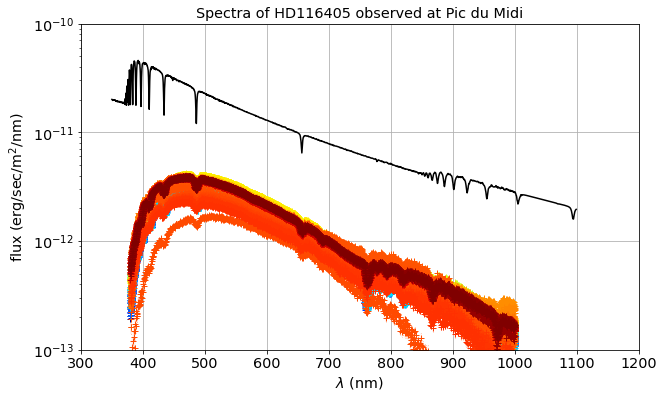

In [74]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=all_df[ifile]

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '+', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(1e-13,1e-10)
ax.set_yscale("log")

(25.0, 35.0)

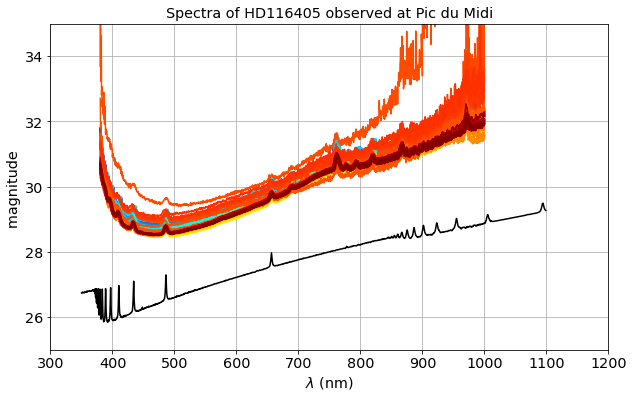

In [75]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=the_df=all_df[ifile]

    ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(25,35)

In [76]:
all_df[0].airmass[0]

1.545960928536013

# Convert Not filtered spectra into Mag table

In [77]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(all_df,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

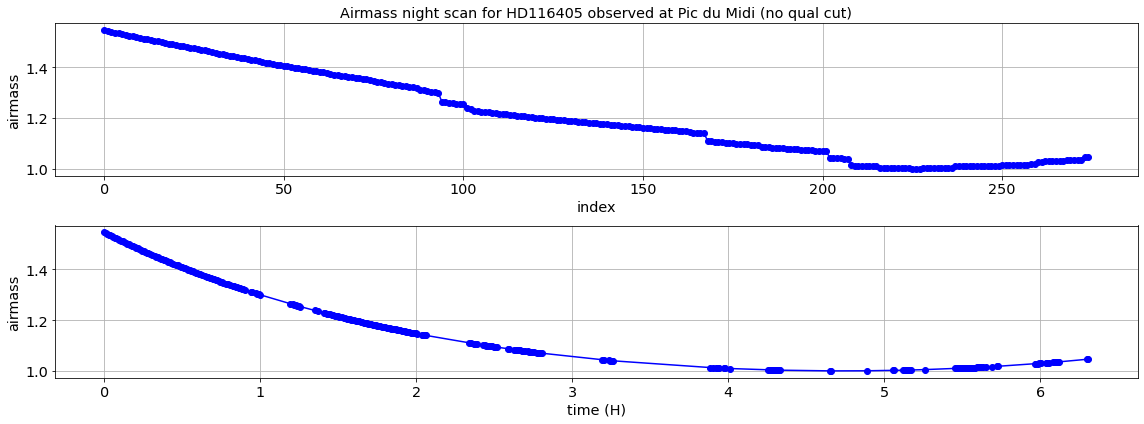

In [78]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Pic du Midi (no qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()

plt.tight_layout()


In [79]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [80]:
MagsRef1=Mags1-sed_mag0

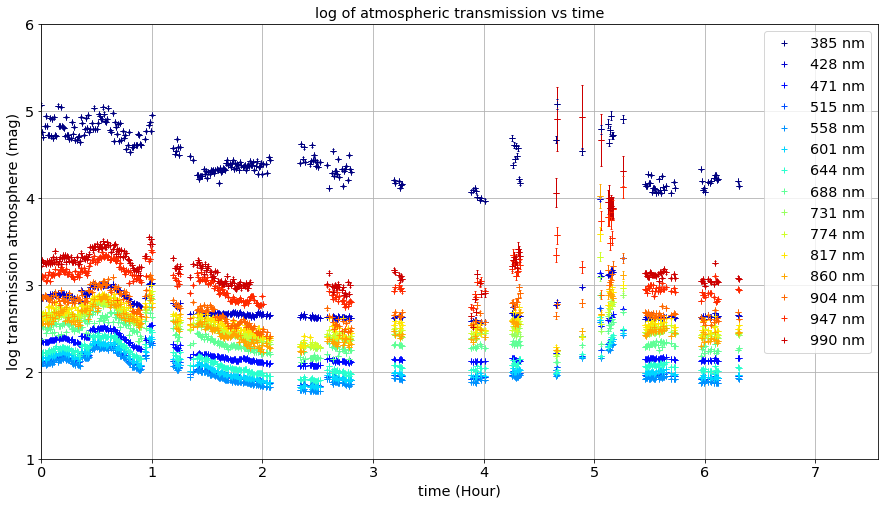

In [81]:
#def GetBouguerLinesTim(Npoints,wl,tim,magref,emag,FLAG_PLOT=True)
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef1,EMags1,FLAG_PLOT=True,YMIN=1,YMAX=6)

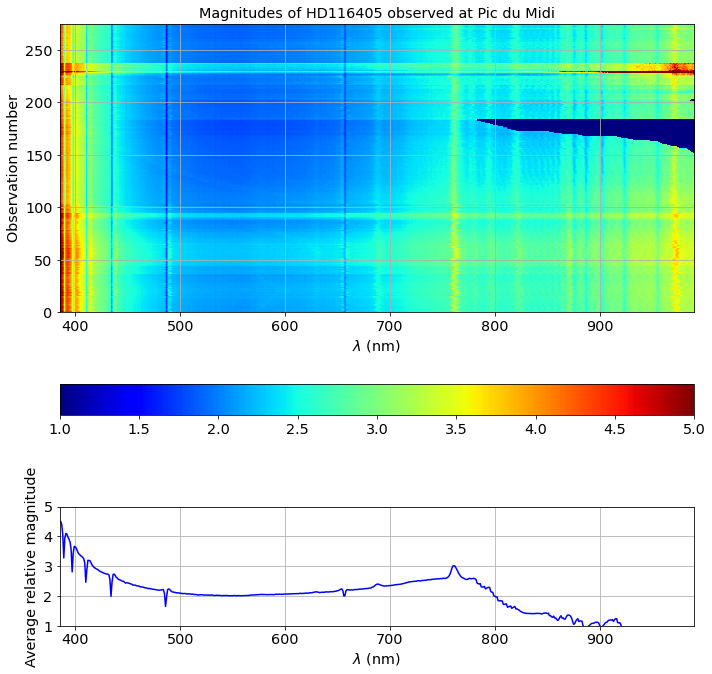

In [82]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBFILES)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef1,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Pic du Midi"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef1,axis=0)
ax2.plot(WL,Y,"b-")
ax2.set_ylim(1,5)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

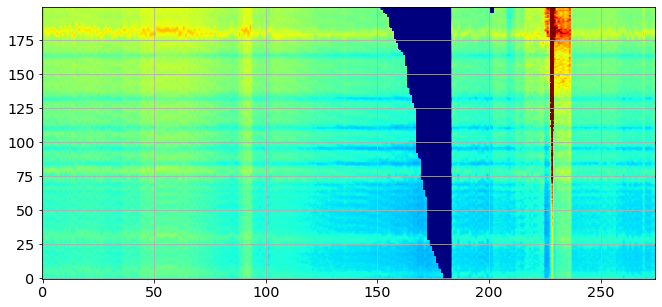

In [83]:
fig=plt.figure(figsize=(11,5))
ax=fig.add_subplot(111)
ax.imshow(MagsRef1[:,-200:].T,origin="lower",norm=norm,cmap="jet",aspect="auto")
ax.grid()

In [84]:
profileY=np.average(MagsRef1[:,-200:],axis=1)

In [85]:
import mpld3
from mpld3 import plugins

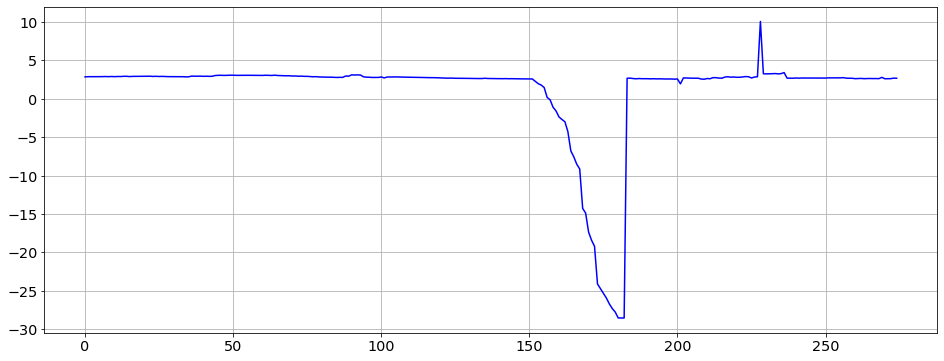

In [86]:
fig=plt.figure(figsize=(16,6))
ax=fig.add_subplot(111)
ax.plot(profileY,'b')
ax.grid()

if 0:
    plugins.connect(fig, plugins.MousePosition(fontsize=14))
    mpld3.show()

# Filtered spectra

In [87]:
#all_df_filt=GetSpectraFiltered(inputdir,selected_files,normalisation_factor=normalisation_factor)
if inputdir == "data":
    all_df_filt=GetSpectraFiltered(inputdir,selected_files,normalisation_factor=normalisation_factor)
else:
    all_df_filt=GetSpectraFiltered_clean(inputdir,selected_files,normalisation_factor=normalisation_factor)   

In [88]:
all_df_filt[0].head()

,count,airmass,time,wavelength,flux,errflux,mag,errmag,abs,errabs,filename
0,0,1.545961,0.0,380.067586,1.906583e-13,4.487186e-15,31.799361,0.023535,28.776280,0.023535,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1,0,1.545961,0.0,380.511009,2.082932e-13,4.521747e-15,31.703312,0.021709,28.682771,0.021709,T1M_20190215_225550_730_HD116405_Filtre_None_b...
2,0,1.545961,0.0,380.954428,2.098480e-13,4.562320e-15,31.695238,0.021741,28.677220,0.021741,T1M_20190215_225550_730_HD116405_Filtre_None_b...
3,0,1.545961,0.0,381.397842,2.313665e-13,4.529898e-15,31.589249,0.019579,28.573740,0.019579,T1M_20190215_225550_730_HD116405_Filtre_None_b...
4,0,1.545961,0.0,381.841250,2.601964e-13,4.679267e-15,31.461747,0.017984,28.448731,0.017984,T1M_20190215_225550_730_HD116405_Filtre_None_b...


# Convert Not filtered spectra into Mag table

In [89]:
NBFILES=len(all_df_filt)

In [90]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

In [91]:
msg=f" Number of good spectra is {NBFILES}"
logger.info(msg)

2020-09-30 23:09:50,260 MacBook-Pro-de-admin.local __main__[5181] INFO  Number of good spectra is 243


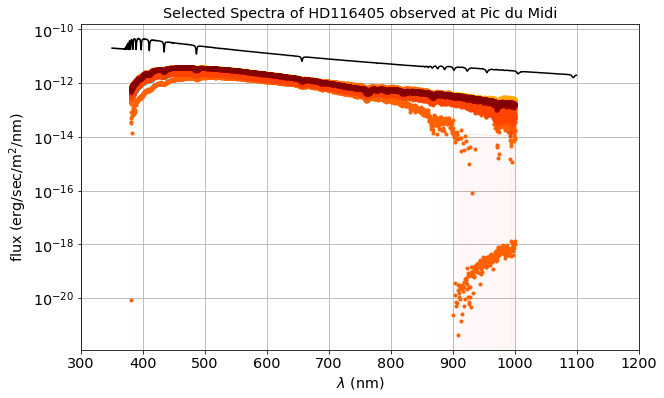

In [92]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=all_df_filt[ifile]

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_yscale("log")

(25.0, 35.0)

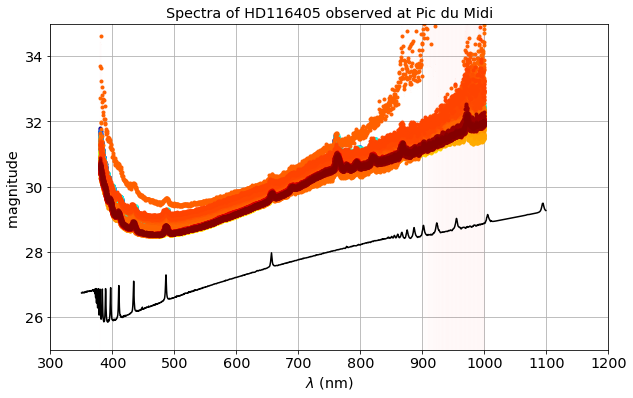

In [93]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=the_df=all_df_filt[ifile]

    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    ax.errorbar(the_df.wavelength,the_df.mag,yerr=the_df.errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(25,35)

## Convert to image

In [94]:
WL,Mags2, EMags2,AirM,Tim = ConvertToImage(all_df_filt,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

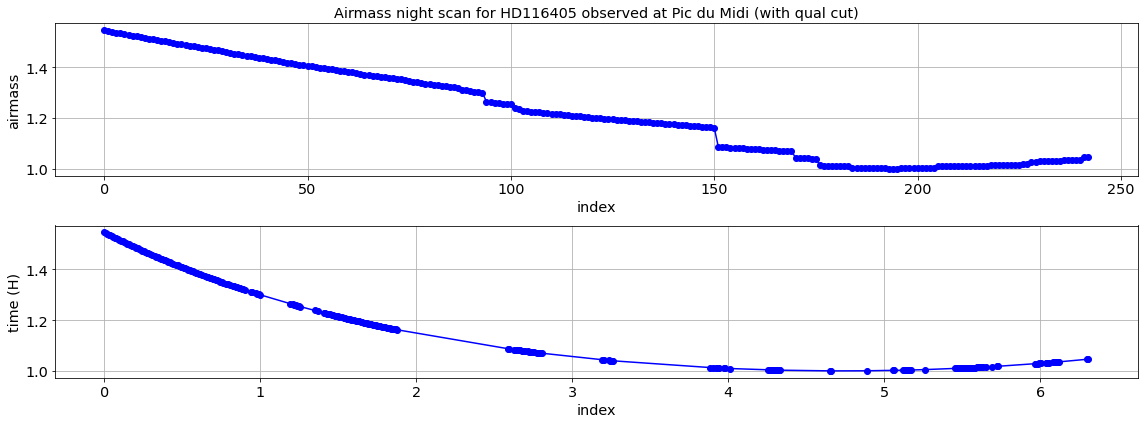

In [95]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Pic du Midi (with qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("time (H)")
ax2.set_xlabel("index")
ax2.grid()

plt.tight_layout()

In [96]:
MagsRef2=Mags2-sed_mag0

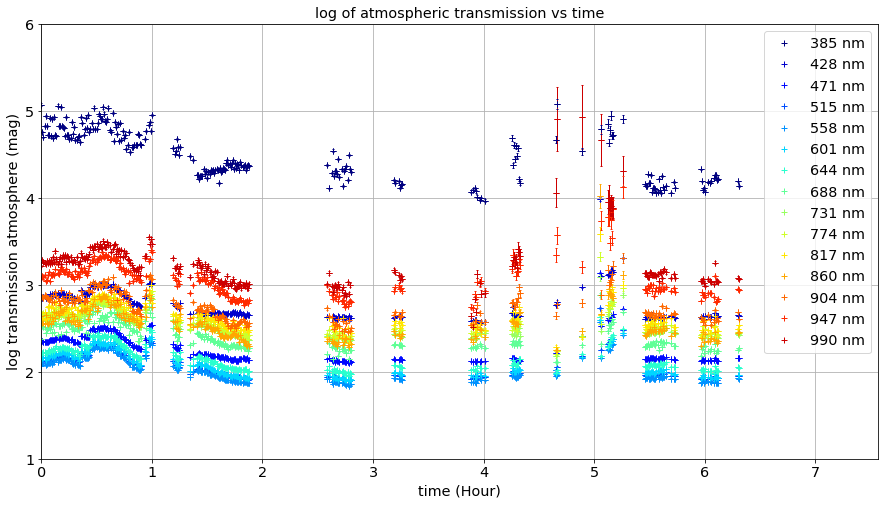

In [97]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef2,EMags2,FLAG_PLOT=True,YMIN=1,YMAX=6)

# Quality selection of observations

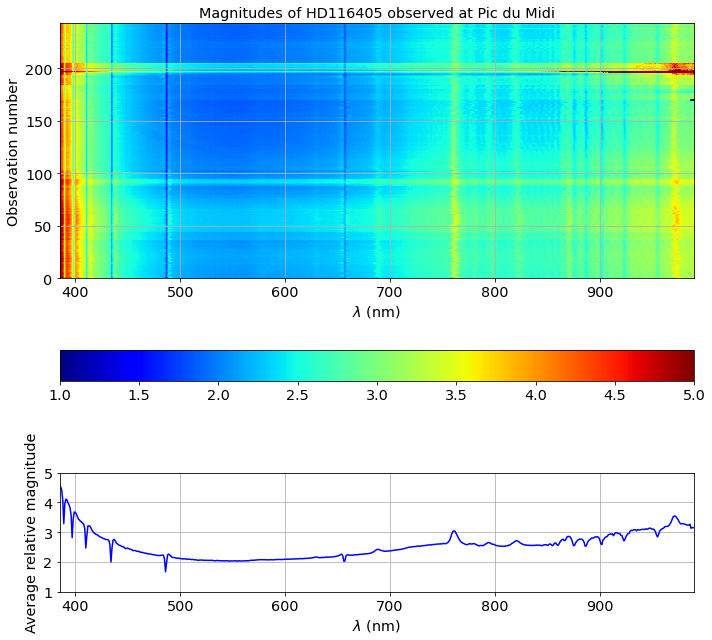

In [98]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBFILES)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef2,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Pic du Midi"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef2,axis=0)
ax2.plot(WL,Y,"b-")
ax2.set_ylim(1,5)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Bouguer line

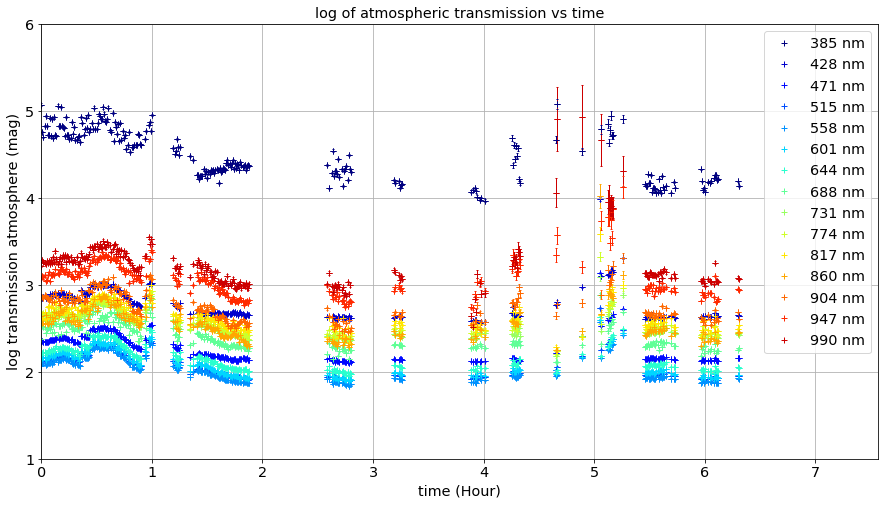

In [99]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef2,EMags2,FLAG_PLOT=True,YMIN=1,YMAX=6)

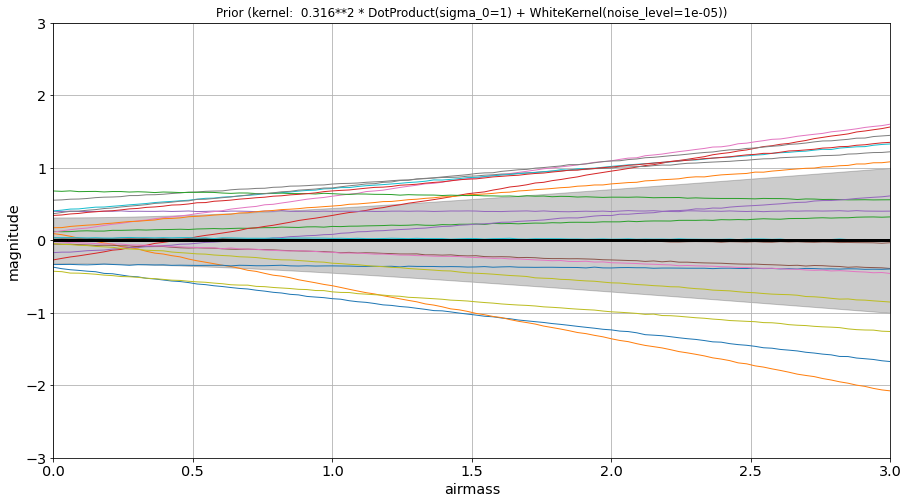

In [100]:
if FLAG_PLOT:
    # Plot prior
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 1, 1)

    X_ = np.linspace(0, 3, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)

    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)

    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 20)

    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 3)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % my_kernel, fontsize=12)
    plt.xlabel("airmass")
    plt.ylabel("magnitude")
    plt.grid()

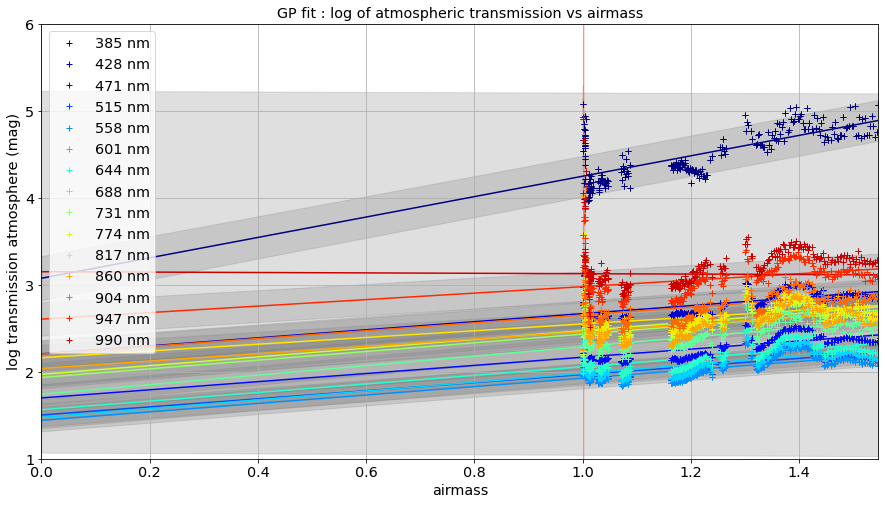

In [101]:
#GetBouguerLinesGP(Npoints,wl,airmass,magref,emag ,FLAG_PLOT=True)
w,m,e=GetBouguerLinesGP(NPOINTSVIEW,WL,AirM,MagsRef2,EMags2,FLAG_PLOT=True,YMIN=1,YMAX=6)

# Optical Throughput

In [102]:
w_s1,m_s1,em_s1=GetBouguerLinesGP(NPOINTSSAVE,WL,AirM,MagsRef2,EMags2,FLAG_PLOT=False)

In [103]:
transm_s1=np.power(10,-m_s1/2.5)
etransm_s1=em_s1*transm_s1

In [104]:
factor=1.0 # suppose Spectractor has divided the flux by Ronchi efficiency
transm_s1=transm_s1*factor
etransm_s1=etransm_s1*factor

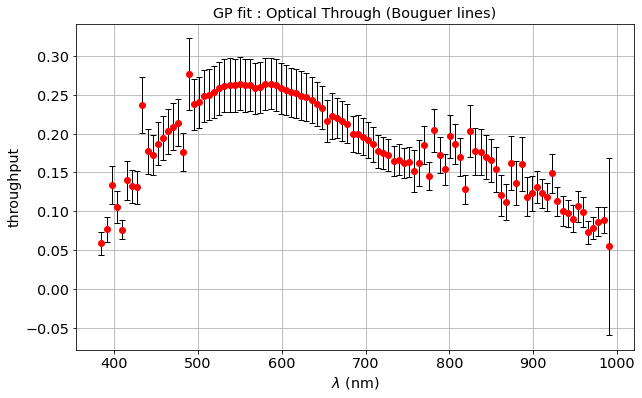

In [105]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(w_s1,transm_s1,yerr=etransm_s1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1)
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"GP fit : Optical Through (Bouguer lines)"
ax.set_title(title)
ax.grid()

# Spectrum at the TOA

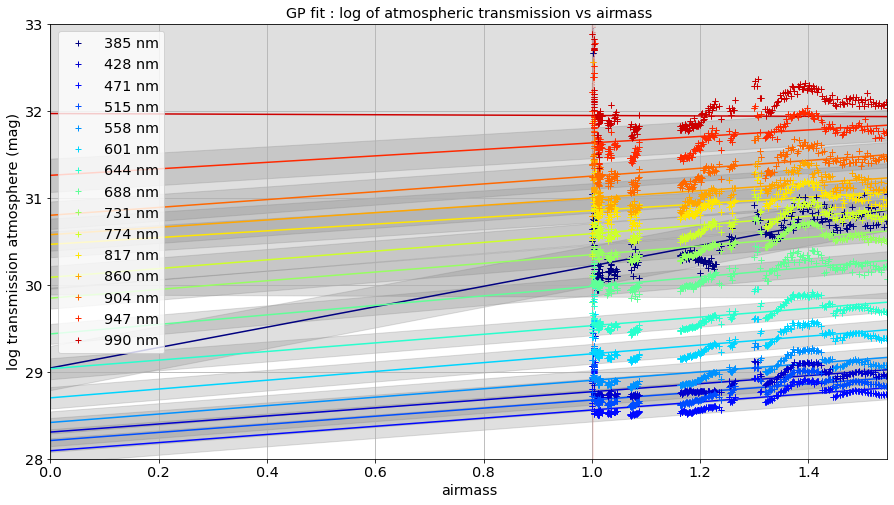

In [106]:
w,m,e=GetBouguerLinesGP(NPOINTSVIEW,WL,AirM,Mags2,EMags2,FLAG_PLOT=True,YMIN=28,YMAX=33)

In [107]:
w_s2,m_s2,em_s2=GetBouguerLinesGP(NPOINTSSAVE,WL,AirM,Mags2,EMags2,FLAG_PLOT=False)

In [108]:
transm_s2=np.power(10,-m_s2/2.5)
etransm_s2=em_s2*transm_s2

In [109]:
factor=1.0 # suppose Spectractor has divided the flux by Ronchi efficiency
transm_s2=transm_s2*factor
etransm_s2=etransm_s2*factor

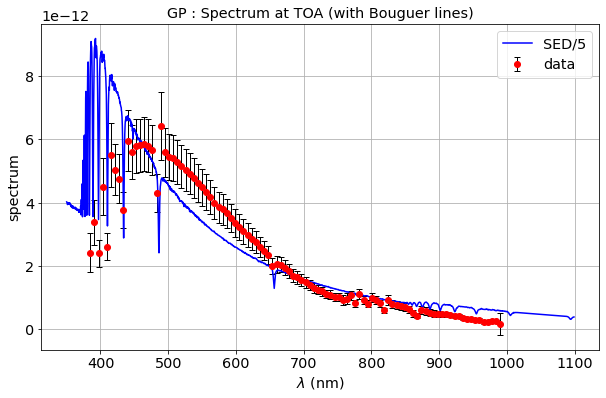

In [110]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(w_s2,transm_s2,yerr=etransm_s2,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
plt.plot(sed_w,sed_f/5,"b-",label="SED/5")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"GP : Spectrum at TOA (with Bouguer lines)"
ax.set_title(title)
ax.legend()
ax.grid()

# Save

In [111]:
dfout = pd.DataFrame()

In [112]:
dfout["wavelength"]=w_s1
dfout["throu"]=transm_s1
dfout["errthrou"]=etransm_s1
dfout["sedtoa"]=transm_s2
dfout["errsedtoa"]=etransm_s2

In [113]:
dfout

,wavelength,throu,errthrou,sedtoa,errsedtoa
0,385.000000,0.058848,0.014968,2.411234e-12,6.132934e-13
1,391.111111,0.076840,0.016336,3.375110e-12,7.175199e-13
2,397.222222,0.134014,0.024208,2.397641e-12,4.331098e-13
3,403.333333,0.105366,0.021108,4.499208e-12,9.013303e-13
4,409.444444,0.076026,0.012338,2.606357e-12,4.229910e-13
...,...,...,...,...,...
95,965.555556,0.072997,0.014951,2.295354e-13,4.701161e-14
96,971.666667,0.078469,0.014122,2.430753e-13,4.374633e-14
97,977.777778,0.086714,0.018647,2.674056e-13,5.750248e-14
98,983.888889,0.088593,0.016423,2.624694e-13,4.865434e-14


In [114]:
#dfout.to_csv("MLfit_bouguer_gp_out.csv")
dfout.to_csv(outputfile_gp) 
 